In [1]:
import kwant 
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, asdict
from kwant.continuum import discretize  
sx = np.array([[0 , 1] , [1 , 0]])
sy = np.array([[0 , -1j] , [1j , 0]])
sz = np.array([[1 , 0] , [0 , -1]])
id = np.array([[1 , 0] , [0 , 1]])
from pfapack import pfaffian as pf

%matplotlib widget

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


### Band structure calculation

Text(0, 0.5, '$\\epsilon(k_{x})$')

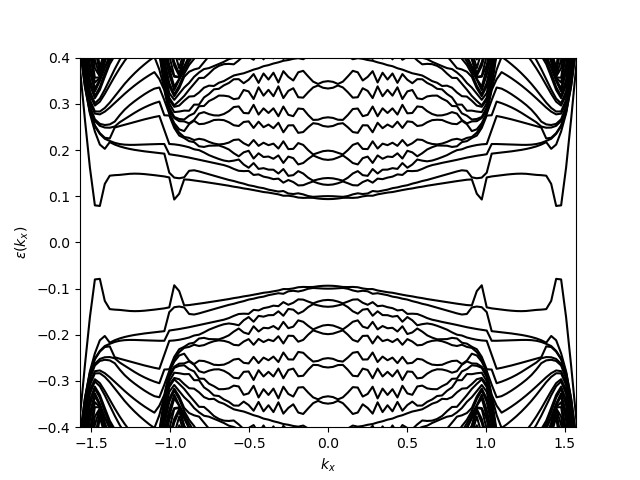

In [2]:
from scipy import constants
from sympy import exp
from josephson_current_tools import constants
@dataclass
class parameters:
    a : float # Lattice constant
    L_x : float # Dimension of planar system in x direction
    L_y : float # Dimension of planar system in y direction
    W : float # Width of the normal region in y direction
    m_eff : float # Effective mass
    mu : float # Chemical potential  
    alpha : float # Rashba coupling
    E_z : float # In plane Zeeman
    Delta : float # Superconducting gap
    phase : float # Phase bias of Josephson junction
    k : float # Boltzmann constant
    T : float # Temperature
    current_unit: float # Current unit

def make_lead(params, plot):
    # Continuum model:
    hamiltonian_bottom = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + 0.5*(m_eff*(alpha**2))*kron(sigma_z, sigma_0) 
    + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + E_z*kron(sigma_0 , sigma_x) + Delta*kron(sigma_x , sigma_0)"""

    hamiltonian_top = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + 0.5*(m_eff*(alpha**2))*kron(sigma_z, sigma_0) 
    + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + E_z*kron(sigma_0 , sigma_x) + 0.5*Delta*exp1*kron(sigma_x + I*sigma_y , sigma_0) 
    + 0.5*Delta*exp2*kron(sigma_x - I*sigma_y , sigma_0) 
    """

    template_sc_top = discretize(hamiltonian_top , locals = {'exp1' : np.exp(1j*params.phase) , 'exp2': np.exp(-1j*params.phase) } ,  grid = params.a )
    template_sc_bottom = discretize(hamiltonian_bottom , grid = params.a)
    template_normal = discretize(hamiltonian_bottom , locals =  {'Delta' : 0 , 'E_z' : 0 } , grid = params.a)

    lead = kwant.Builder(kwant.TranslationalSymmetry((-params.a , 0)))

    # Modified shape functions for a translationall invariant lead in the x-direction:
    half_w = params.W // 2
    half_L_y = params.L_y // 2

    def normal_region_color(site):
        if normal_region(site) == True:
            return 'red'
        else: 
            return 'blue'

    def normal_region(site):
        (x , y) = site.pos
        return ((half_L_y - half_w)< y < (half_L_y + half_w))
    
    def bottom_super_region(site):
        (x , y) = site.pos
        return (0 <=y <= (half_L_y - half_w))
    
    def top_super_region(site):
        (x , y) = site.pos
        return ((half_L_y + half_w)  <= y < params.L_y)
    
    lead.fill(template_sc_bottom , bottom_super_region , (0 , 0) )
    lead.fill(template_normal , normal_region , (0 , (half_L_y - half_w) + 1))
    lead.fill(template_sc_top , top_super_region , (0 , (half_L_y + half_w)))

    if plot == True:
        kwant.plot(lead , site_lw = 0.1 ,  site_color = normal_region_color );
    return lead.finalized()

params = parameters(a = 0.5 , L_x = 0, L_y = 61 , W  = 5 , m_eff = 1, mu = 2.8 , alpha = 0.5 , E_z= 0.2 , Delta = 0.3 , phase = np.pi*0.0, k = constants.k , T = 0.05 , current_unit = constants.current_unit)
syst  = make_lead(params , plot = False)

# Plotting band structure of the Josephson junction: 
bands = kwant.physics.Bands(syst , params = asdict(params))
momenta = np.linspace(-np.pi , np.pi , 201)
energies = [bands(k) for k in momenta]
fig , ax = plt.subplots()
ax.plot(momenta , energies , color = 'k');
ax.set_xlim(left = -np.pi/2 , right = np.pi/2)
ax.set_ylim(bottom = -params.Delta - 0.1 , top = params.Delta + 0.1)
ax.set_xlabel(r'$k_{x}$')
ax.set_ylabel(r'$\epsilon(k_{x})$')

### Phase diagram calculation:

Testing Pfaffian expression for the $\mathbb{Z}$ invariant:
$$ \mathcal{Q} = \frac{Pf[\mathcal{H}(k = \pi) \sigma_{y}\tau_{y}]}{Pf[\mathcal{H}(k = 0) \sigma_{y}\tau_{y}]} $$


In [3]:
def z_invariant(ham_0 , ham_pi):
    """ Given a bloch Hamiltonians at k = 0 and k = \pi, this function calculates the Z invariant for the wire using the Pfaffian formula for particle-hole symmetric Hamiltonians"""
    # Calculating the number of sites:
    shape = ham_0.shape[0]
    no_sites = shape // 4

    # Constructing particle-hole symmetry operator:
    P = np.kron(sy , sy)

    # Apply particle-hole operator on each site:
    identity = np.identity(no_sites)
    P_allsites = np.kron(identity , P)

    # Calculating pfaffians:
    numerator = pf.pfaffian(ham_pi@P_allsites)
    denominator = pf.pfaffian(ham_0@P_allsites)
    
    # Invariant:
    Q = np.sign(numerator / denominator)

    return Q

def bloch_hamiltonian(band_object , k):
    """
    Calculates the Bloch vector at wave vector k:
    H(k) = H_onsites + V_{hop} exp(-ik) + V_{hop}^{\dagger} exp(ik) 

    which is solved for the bands at k :
    H(k) \Psi = E\Psi

    Inputs:
    band_object : kwant.physis.Bands object for system.
    k: momentum number
    """
    ham_onsite = band_object.ham
    V_hop = band_object.hop

    hopping_matrix = V_hop * (np.cos(k) - 1j*np.sin(k))

    # Bloch Hamiltonian matrix:
    H_k = ham_onsite + hopping_matrix + hopping_matrix.conjugate().transpose()

    return H_k


# Calculating the Bloch hamiltonians:
ham_0 = bloch_hamiltonian(bands , 0)
ham_pi = bloch_hamiltonian(bands , np.pi)

Q = z_invariant(ham_0 , ham_pi)

print(Q)


(1+0j)


Phase diagram:

In [8]:
phase_values = np.linspace(0 , 2, 41)
zee_values = np.linspace(0 , 1 , 51)

chern_numbers = np.zeros(shape = (len(phase_values) , len(zee_values)))
from tqdm import tqdm

for i in tqdm(range(len(phase_values))):
    for j in tqdm(range(len(zee_values))):
        params = parameters(a = 0.5 , L_x = 0, L_y = 45 , W  = 5 , m_eff = 2, mu = 2.8 , alpha = 0.5 , E_z= zee_values[j] , Delta = 0.5 , phase = np.pi*phase_values[i], k = constants.k , T = 0.05 , current_unit = constants.current_unit)
        syst  = make_lead(params , plot = False)
        bands = kwant.physics.Bands(syst , params = asdict(params))

        ham_0 = bloch_hamiltonian(bands , 0)
        ham_pi = bloch_hamiltonian(bands , np.pi)

        chern_numbers[i , j] = z_invariant(ham_0 , ham_pi).real

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 41/41 [13:03<00:00, 19.10s/it]


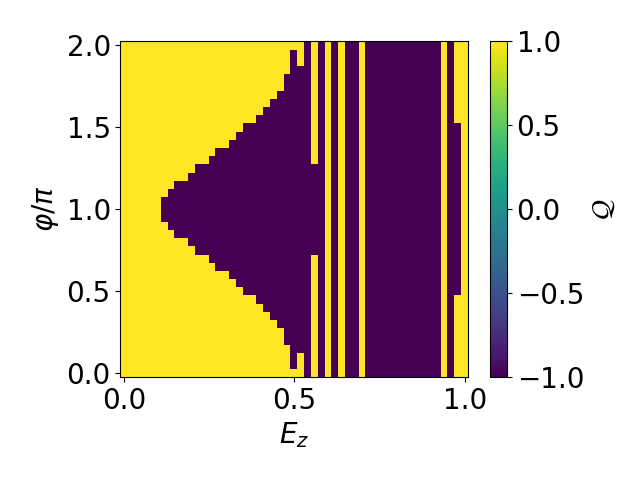

In [12]:
import matplotlib as mpl

mpl.rcParams.update({'font.size': 20})


fig , ax = plt.subplots()
Z , Phi = np.meshgrid(zee_values , phase_values)

im = ax.pcolor(Z , Phi , chern_numbers)
ax.set_xlabel(r'$E_{z}$')
ax.set_ylabel(r'$\varphi / \pi$')
plt.colorbar(mappable = im , label = r'$\mathcal{Q}$')

plt.tight_layout() 
